# Initialize

## ASW session

In [2]:
import boto3

session = boto3.Session()
s3 = session.resource('s3')

## SageMaker Session

In [3]:
import sagemaker

sage_session = sagemaker.Session()

# Define Globals

In [4]:
# bucket name
bucket = 'aida-project'

# path for s3_input
s3_path = f"s3://{bucket}/"

## define source files
# TRAIN source file
train_source_path = 'team_remote'
train_source_name = 'title-train-princ4.csv'
#train_source_name = 'title-valid.csv'       # for testing; remove later


# VALID source file
valid_source_path = 'team_remote'
valid_source_name = 'title-valid-princ4.csv'
#valid_source_name = 'title-test.csv'       # for testing; remove later

# TEST source file
test_source_path = 'team_remote'
test_source_name = 'title-test-princ4.csv'

# output for result
output_path ='team_remote'
output_location = f'{s3_path}{output_path}/output'

In [5]:
print(output_location)

s3://aida-project/team_remote/output


In [6]:
# Create pointers to the S3 train and test datasets

from sagemaker import s3_input

# print(f"{s3_path}{train_source_path}/{train_source_name}")
# print(f"{s3_path}{valid_source_path}/{valid_source_name}")
# print(f"{s3_path}{test_source_path}/{test_source_name}")
s3_input_train = sagemaker.session.s3_input(s3_data=f"{s3_path}{train_source_path}/{train_source_name}", content_type="text/csv")
s3_input_valid = sagemaker.session.s3_input(s3_data=f"{s3_path}{valid_source_path}/{valid_source_name}", content_type="text/csv")
s3_input_test = sagemaker.session.s3_input(s3_data=f"{s3_path}{test_source_path}/{test_source_name}", content_type="text/csv")

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [7]:
role = sagemaker.get_execution_role()

# Define Model

In [8]:
# finde pre-defined models here:
# https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html

# Create an XGBoost Estimator

# estimator call
# <ecr_path>/sagemaker-xgboost:1.2-1
    
ecr_path = "492215442770.dkr.ecr.eu-central-1.amazonaws.com"
xgboost_estimator = f"{ecr_path}/sagemaker-xgboost:1.0-1-cpu-py3"

# ecr_path = "664544806723.dkr.ecr.eu-central-1.amazonaws.com"
# knn_estimator = f"{ecr_path}/knn:latest"


In [9]:
xgboost = sagemaker.estimator.Estimator(xgboost_estimator,
                              role,
                              train_instance_count=1,
                              train_instance_type="ml.m5.4xlarge",
                              output_path=output_location,
                              sagemaker_session=sage_session,
                              base_job_name="JPC-xgboost")

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [10]:
# Select the your specific hyperparameters (Optional)
# https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html
# https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst#learning-task-parameters 

xgboost.set_hyperparameters(
    eta=.35,
    num_round=50,                     # required parameter!
    objective = 'reg:linear',
    )

## Debug Mode
The following esitmator configuration is based on this article:


https://awsfeed.com/whats-new/machine-learning/ml-explainability-with-amazon-sagemaker-debugger

In [11]:
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig, CollectionConfig
from sagemaker.estimator import Estimator 
save_interval = 10
xgboost_debugger = Estimator( role=role, 
                             base_job_name="JPC-xgboost-debug", 
                             train_instance_count=1, 
                             train_instance_type='ml.m5.4xlarge', 
                             image_name=xgboost_estimator, 
                             #hyperparameters=hyperparameters, 
                             train_max_run=1800, 
                             debugger_hook_config=DebuggerHookConfig( s3_output_path=output_location, # Required 
                             collection_configs=[ CollectionConfig( name="feature_importance", parameters={ "save_interval": str(save_interval) } ), ], ), 
                              rules=[ Rule.sagemaker( rule_configs.loss_not_decreasing(), 
                                                     rule_parameters={ "collection_names": "metrics", "num_steps": str(save_interval * 2), }, ), ]
)
xgboost_debugger.set_hyperparameters(
    eta=.35,
    num_round=52,                     # required parameter!
    objective = 'reg:linear',
    )

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


## Fit Model

In [12]:
xgboost_debugger.fit({"train": s3_input_train, "validation": s3_input_valid}, wait=True)

2020-11-20 07:05:30 Starting - Starting the training job...
2020-11-20 07:05:54 Starting - Launching requested ML instances
********* Debugger Rule Status *********
*
*  LossNotDecreasing: InProgress        
*
****************************************
......
2020-11-20 07:06:54 Starting - Preparing the instances for training......
2020-11-20 07:07:55 Downloading - Downloading input data
2020-11-20 07:07:55 Training - Downloading the training image..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:linear to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[07:08:08] 804606x74 matrix with 5

In [13]:
xgboost_debugger.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:eu-central-1:898627427171:processing-job/jpc-xgboost-debug-2020-11--lossnotdecreasing-302b3a73',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2020, 11, 20, 7, 11, 38, 905000, tzinfo=tzlocal())}]

In [14]:
#!pip install smdebug
from smdebug.trials import create_trial
s3_output_path = xgboost_debugger.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2020-11-20 07:14:44.829 ip-172-16-29-248:13719 INFO s3_trial.py:42] Loading trial debug-output at path s3://aida-project/team_remote/output/JPC-xgboost-debug-2020-11-20-07-05-30-203/debug-output


In [15]:
trial.tensor

[2020-11-20 07:14:46.347 ip-172-16-29-248:13719 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2020-11-20 07:14:47.365 ip-172-16-29-248:13719 INFO trial.py:210] Loaded all steps


<bound method Trial.tensor of <smdebug.trials.s3_trial.S3Trial object at 0x7f71c47724a8>:(
    name=debug-output,
    path=s3://aida-project/team_remote/output/JPC-xgboost-debug-2020-11-20-07-05-30-203/debug-output/,
    steps=[0, 10, 20, 30, 40, 50],
    collections=['hyperparameters', 'metrics', 'predictions', 'labels', 'feature_importance', 'average_shap', 'full_shap', 'trees', 'default', 'losses'],
    tensor_names=['feature_importance/cover/f0', 'feature_importance/cover/f1', 'feature_importance/cover/f10', 'feature_importance/cover/f11', 'feature_importance/cover/f12', 'feature_importance/cover/f13', 'feature_importance/cover/f14', 'feature_importance/cover/f15', 'feature_importance/cover/f16', 'feature_importance/cover/f17', 'feature_importance/cover/f18', 'feature_importance/cover/f19', 'feature_importance/cover/f2', 'feature_importance/cover/f20', 'feature_importance/cover/f22', 'feature_importance/cover/f23', 'feature_importance/cover/f24', 'feature_importance/cover/f25', 'fe

In [16]:
trial.tensor_names()

['feature_importance/cover/f0',
 'feature_importance/cover/f1',
 'feature_importance/cover/f10',
 'feature_importance/cover/f11',
 'feature_importance/cover/f12',
 'feature_importance/cover/f13',
 'feature_importance/cover/f14',
 'feature_importance/cover/f15',
 'feature_importance/cover/f16',
 'feature_importance/cover/f17',
 'feature_importance/cover/f18',
 'feature_importance/cover/f19',
 'feature_importance/cover/f2',
 'feature_importance/cover/f20',
 'feature_importance/cover/f22',
 'feature_importance/cover/f23',
 'feature_importance/cover/f24',
 'feature_importance/cover/f25',
 'feature_importance/cover/f26',
 'feature_importance/cover/f27',
 'feature_importance/cover/f28',
 'feature_importance/cover/f29',
 'feature_importance/cover/f3',
 'feature_importance/cover/f30',
 'feature_importance/cover/f31',
 'feature_importance/cover/f32',
 'feature_importance/cover/f33',
 'feature_importance/cover/f34',
 'feature_importance/cover/f35',
 'feature_importance/cover/f36',
 'feature_impo

In [17]:
trial.tensor("feature_importance/cover/f0").values()

{10: array([0.04902172]),
 20: array([0.06575045]),
 30: array([0.0547872]),
 40: array([0.04975778]),
 50: array([0.01799525])}

In [18]:
liste = trial.tensor_names()

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import re


def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

def plot_collection(trial, collection_name, regex='.*', figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and 
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.despine()

    tensors = trial.collection(collection_name).tensor_names

    for tensor_name in sorted(tensors):
        if re.match(regex, tensor_name):
            steps, data = get_data(trial, tensor_name)
            ax.plot(steps, data, label=tensor_name)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Iteration')

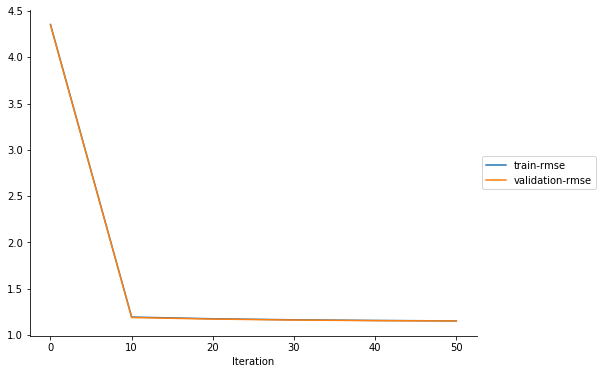

In [20]:
plot_collection(trial, "metrics")

In [21]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(
        trial,
        "feature_importance",
        regex=f"feature_importance/{importance_type}/.*")

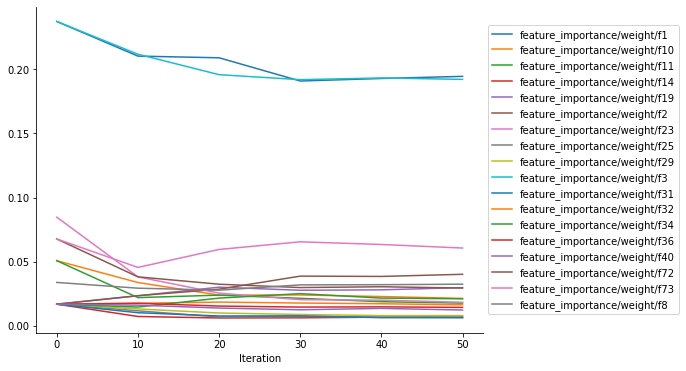

In [22]:
plot_feature_importance(trial)

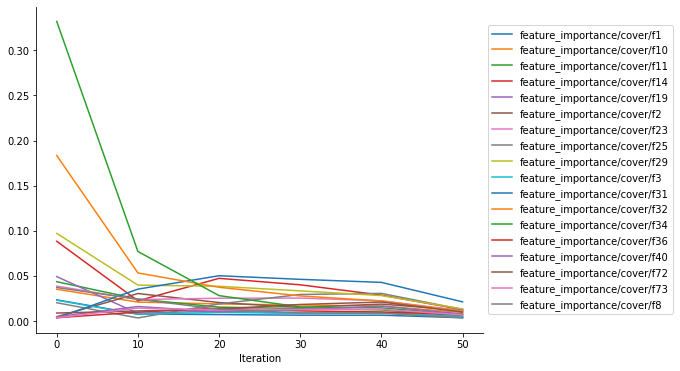

In [23]:
plot_feature_importance(trial, importance_type="cover")

In [23]:
#[k for k in lst if 'ab' in k]
feature_importance_names = [k for k in liste if 'feature_importance/cover' in k]
feature_importance_col_names = ['isAdult', 'startYear', 'endYear', 'numVotes', 'Crime', 'Romance', 'Thriller', 'Adventure', 'Drama', 'War', 'Documentary', 'Reality-TV', 'Family', 'Fantasy', 'Game-Show', 'Adult', 'History', 'Mystery', 'Musical', 'Animation', 'Music', 'Film-Noir', 'shortGenre', 'Horror', 'Western', 'Biography', 'Comedy', 'Action', 'Sport', 'Talk-Show', 'Sci-Fi', 'News', 'movie', 'short', 'tvEpisode', 'tvMiniSeries', 'tvMovie', 'tvSeries', 'tvShort', 'tvSpecial', 'video', 'videoGame', 'nm0592314', 'nm10514069', 'nm11131030', 'nm11131593', 'nm1915152', 'nm2124199', 'nm2299581', 'nm2699546', 'nm3816718', 'nm4837590', 'nm5181169', 'nm5511980', 'nm6135542', 'nm6419589', 'nm7155068', 'nm7702567', 'nm8062068', 'nm8079243', 'nm8269207', 'nm8409754', 'nm8641187', 'nm8688464', 'nm8713978', 'nm8741892', 'nm9002892', 'nm9099684', 'nm9099685', 'nm9177141', 'nm9325202', 'nm9354107', 'distinct languages', 'distinct regions']
print(feature_importance_names)

['feature_importance/cover/f0', 'feature_importance/cover/f1', 'feature_importance/cover/f10', 'feature_importance/cover/f11', 'feature_importance/cover/f12', 'feature_importance/cover/f13', 'feature_importance/cover/f14', 'feature_importance/cover/f15', 'feature_importance/cover/f16', 'feature_importance/cover/f17', 'feature_importance/cover/f18', 'feature_importance/cover/f19', 'feature_importance/cover/f2', 'feature_importance/cover/f20', 'feature_importance/cover/f22', 'feature_importance/cover/f23', 'feature_importance/cover/f24', 'feature_importance/cover/f25', 'feature_importance/cover/f26', 'feature_importance/cover/f27', 'feature_importance/cover/f28', 'feature_importance/cover/f29', 'feature_importance/cover/f3', 'feature_importance/cover/f30', 'feature_importance/cover/f31', 'feature_importance/cover/f32', 'feature_importance/cover/f33', 'feature_importance/cover/f34', 'feature_importance/cover/f35', 'feature_importance/cover/f36', 'feature_importance/cover/f37', 'feature_im

In [24]:
feat_dict_10={}
feat_dict_50={}
for i,f in enumerate(feature_importance_names):
    index=int(f.split('f')[2])
    print(feature_importance_col_names[i],"\t\t",end='')

    
    try:
        feat_dict_10[feature_importance_col_names[index]]=trial.tensor(f).values()[10][0]
    except:
        feat_dict_10[feature_importance_col_names[index]]=0
    #print(f,index)
print(feat_dict_10)
print(30*'*')
print()
for i,f in enumerate(feature_importance_names):
    index=int(f.split('f')[2])
    try:
        feat_dict_50[feature_importance_col_names[index]+' '+f.split('/')[2]]=trial.tensor(f).values()[50][0]
    except:
        feat_dict_50[feature_importance_col_names[index]+' '+f.split('/')[2]]=0
   
print(feat_dict_50)

isAdult 		startYear 		endYear 		numVotes 		Crime 		Romance 		Thriller 		Adventure 		Drama 		War 		Documentary 		Reality-TV 		Family 		Fantasy 		Game-Show 		Adult 		History 		Mystery 		Musical 		Animation 		Music 		Film-Noir 		shortGenre 		Horror 		Western 		Biography 		Comedy 		Action 		Sport 		Talk-Show 		Sci-Fi 		News 		movie 		short 		tvEpisode 		tvMiniSeries 		tvMovie 		tvSeries 		tvShort 		tvSpecial 		video 		videoGame 		nm0592314 		nm10514069 		nm11131030 		nm11131593 		nm1915152 		nm2124199 		nm2299581 		nm2699546 		nm3816718 		{'isAdult': 0.04902172450760012, 'startYear': 0.007731743678272502, 'Documentary': 0.020954070611763607, 'Reality-TV': 0.024340919937262895, 'Family': 0.002816347625729448, 'Fantasy': 0.014046750999490027, 'Game-Show': 0.022368419586286808, 'Adult': 0.0001551272228130691, 'History': 0.07654415411172315, 'Mystery': 0.0019654479604704414, 'Musical': 0.0023012229271350006, 'Animation': 0.00846598415249249, 'endYear': 0.03043580177121961, 'Music': 0.013500729

In [21]:
feat_weight_dict={}
for i,f in enumerate(feature_importance_weight):
    print(feature_importance_col_names[i],"\t\t",end='')
    print(trial.tensor(f).values())
    #print(trial.tensor(f).values()[40][0])
    feat_weight_dict[feature_importance_col_names[i]]=trial.tensor(f).values()[50][0]
    #break
#print(feat_weight_dict)

NameError: name 'feature_importance_weight' is not defined

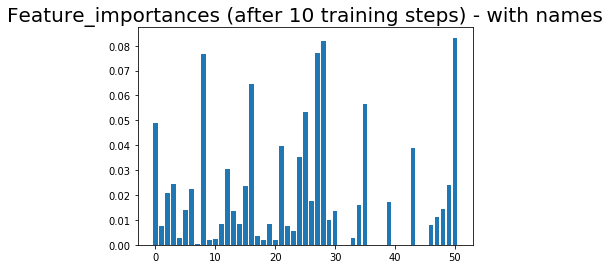

Text(0.5, 1.0, 'Feature_importances (after 50 training steps) - with names')

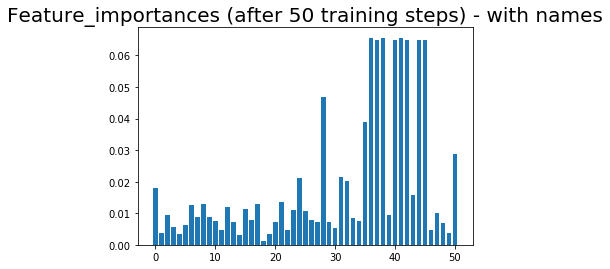

In [25]:
import matplotlib.pyplot as plt
plt.bar(range(len(feat_dict_10)),list(feat_dict_10.values()))
plt.title("Feature_importances (after 10 training steps) - with names", fontsize=20)
plt.show()
plt.bar(range(len(feat_dict_50)),list(feat_dict_50.values()))
plt.title("Feature_importances (after 50 training steps) - with names", fontsize=20)

Text(0.5, 1.0, 'Feature_importances_weight')

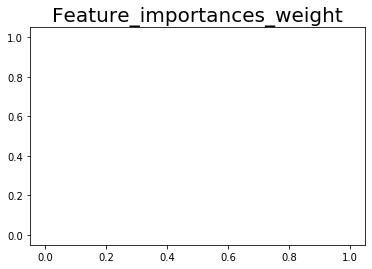

In [26]:
plt.bar(range(len(feat_weight_dict)),list(feat_weight_dict.values()))
plt.title("Feature_importances_weight", fontsize=20)

In [27]:
import pandas as pd




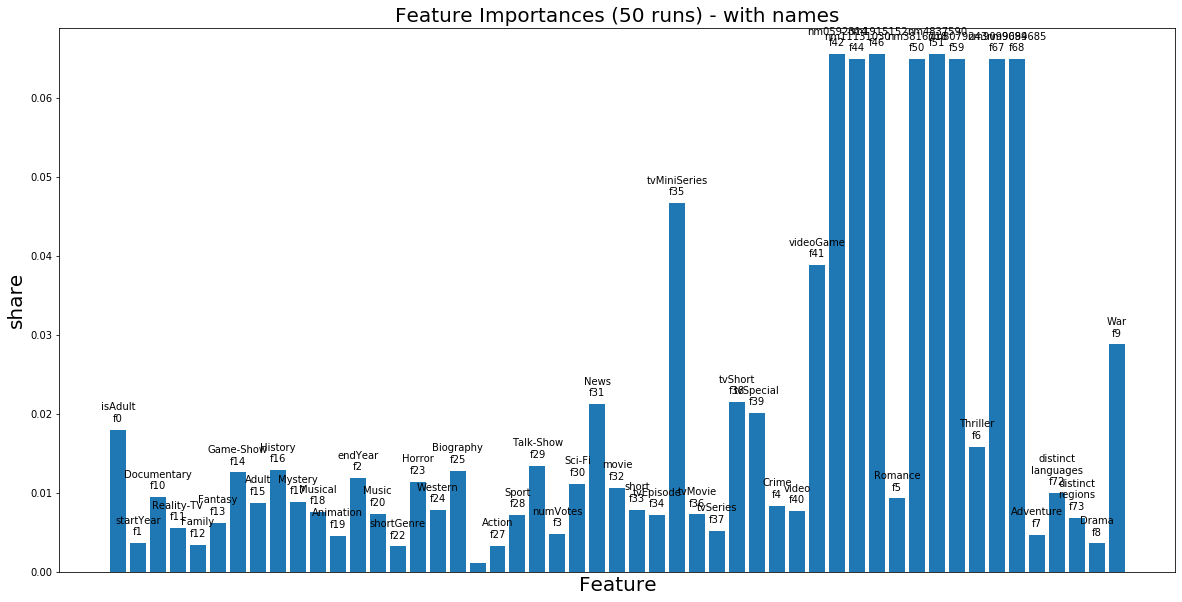

In [28]:
from datetime import datetime

now = datetime.now() # current date and time
time = now.strftime("%m-%d-%Y-%H-%M-%S")
#print(time)

dict = feat_dict_50

fig,ax = plt.subplots(figsize=(20,10))

#pd.DataFrame(feat_dict, index=['quantity']).plot(kind='bar',ax=ax,use_index=False, legend=False,width=1.4)
plt.bar(*zip(*dict.items()))
plt.title('Feature Importances (50 runs) - with names', fontsize=20)
plt.xlabel('Feature', fontsize=20)
plt.ylabel('share', fontsize=20)
plt.xticks(ticks=[])
threshold=0.002
pad=0.001
i=0
for k,v in dict.items():
    if v > threshold:
        ax.text(i,v+pad,k.replace(" ","\n"),horizontalalignment='center',fontsize=10)
    #reak
    i +=1
#plt.xlim([0,10])
#plt.ylim([0,10])
#plt.plot([0,10],[0,10], c='red')

#plt.show()
save_it=True
if save_it == True:
    filename='Feature_importance_princ-'+time
    plt.savefig(filename, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait')
plt.show()

In [35]:
principal_names = pd.read_csv(f'{s3_path}{output_path}/principals01.csv', header=None, names=['ncsont', 'name']).set_index('nconst', inplace=True)
principal_names.head()


MemoryError: Unable to allocate 74.1 MiB for an array with shape (9711022,) and data type object

In [130]:
sum=0
for k,v in feat_dict_50.items():
    sum=sum+v
print(sum)

1.0


# Deploy Model

## Deploy

In [24]:
# Deploy  model to an endpoint

xgb_predictor = xgboost_debugger.deploy(
    initial_instance_count = 1, 
    instance_type = 'ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!

## Configure Predictor

In [25]:
# Configure the predictor's serializer and deserializer

# INSERT CODE HERE

from sagemaker.predictor import csv_serializer, json_deserializer

xgb_predictor.content_type = "text/csv"
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = json_deserializer

# Display Endpoint

In [26]:
xgb_predictor.endpoint

'JPC-xgboost-debug-2020-11-20-07-05-30-203'

# Prediction

In [31]:
import pandas as pd
test = pd.read_csv(f"{s3_path}{test_source_path}/{test_source_name}", header=0, index_col=False, names=col_names)
prediction=[]


IndexError: list index out of range

In [32]:
f"{s3_path}{test_source_path}/{test_source_name}"


's3://aida-project/team_remote/title-test-princ4.csv'

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000


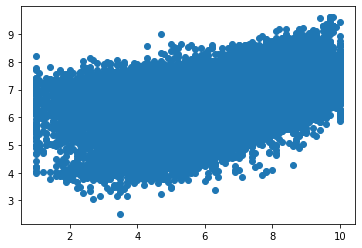

In [33]:
# carefully just one prediction
import pandas as pd
import matplotlib.pyplot as plt

col_names = ['averageRating', 'isAdult', 'startYear', 'endYear', 'numVotes', 'Crime', 'Romance', 'Thriller', 'Adventure', 'Drama', 'War', 'Documentary', 'Reality-TV', 'Family', 'Fantasy', 'Game-Show', 'Adult', 'History', 'Mystery', 'Musical', 'Animation', 'Music', 'Film-Noir', 'shortGenre', 'Horror', 'Western', 'Biography', 'Comedy', 'Action', 'Sport', 'Talk-Show', 'Sci-Fi', 'News', 'movie', 'short', 'tvEpisode', 'tvMiniSeries', 'tvMovie', 'tvSeries', 'tvShort', 'tvSpecial', 'video', 'videoGame', 'distinct languages', 'distinct regions']
test = pd.read_csv(f"{s3_path}{test_source_path}/{test_source_name}")#, header=0, index_col=False, names=col_names)
prediction=[]
for i in range(test.shape[0]):
    prediction.append(xgb_predictor.predict(test.iloc[i, 1:]))
    if i % 5000 == 0:
        print(i)
    #     print(prediction)
    #     print(test.iloc[i,0])
#print(prediction) 

plt.scatter(test.iloc[:,0], prediction)


11-20-2020-08-23-54


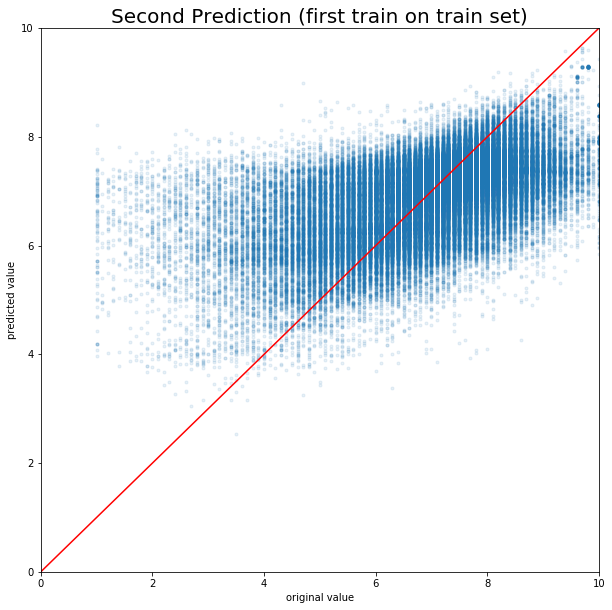

In [37]:
from datetime import datetime

now = datetime.now() # current date and time
time = now.strftime("%m-%d-%Y-%H-%M-%S")
print(time)



fig = plt.subplots(figsize=(10,10))
plt.scatter(test.iloc[:,0], prediction,marker='.', alpha=.1)
plt.title('Second Prediction (first train on train set)', fontsize=20)
plt.xlabel('original value')
plt.ylabel('predicted value')
plt.xlim([0,10])
plt.ylim([0,10])
plt.plot([0,10],[0,10], c='red')

#plt.show()
filename='Prediction-'+time
plt.savefig(filename, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait')


11-18-2020-14-55-10
